In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import os
import pylab as pl
import sys
import xarray as xr
import yaml

### Files paths

In [2]:
yaml_file = './config.yaml'
params = yaml.safe_load(open(yaml_file))

INPUT_GRID = params['input_grid_nc']
INPUT_PATH_SSH_FILTERED = params['input_path_data_filtered']
INPUT_PATH_SEG_MASKS = params['input_path_data_seg_masks']

# TODO optional, I may just do the whole processing here
OUTPUT_PATH_GRID_SUBSET = params['output_path_grid_subset']

# TODO: for every path in SSH, read the file and (delete the useless field)
# concatenate them, or read them with open_mfdataset()

### Read and print the mesh

In [3]:
data_mesh = xr.open_dataset(INPUT_GRID, engine='netcdf4')
data_mesh

<xarray.Dataset>
Dimensions:            (nz: 70, nz1: 69, elem: 17628297, nod2: 8852366, n3: 3,
                        n2: 2, N: 8, edg_n: 26481174, n4: 4)
Coordinates:
  * nz                 (nz) float64 0.0 -5.0 -10.0 ... -6e+03 -6.35e+03
  * nz1                (nz1) float64 -2.5 -7.5 -12.5 ... -5.825e+03 -6.175e+03
Dimensions without coordinates: elem, nod2, n3, n2, N, edg_n, n4
Data variables: (12/19)
    elem_area          (elem) float64 ...
    nlevels_nod2D      (nod2) int32 ...
    nlevels            (elem) int32 ...
    nod_in_elem2D_num  (nod2) int32 ...
    nod_part           (nod2) int32 ...
    elem_part          (elem) int32 ...
    ...                 ...
    nod_in_elem2D      (N, nod2) int32 ...
    edges              (n2, edg_n) int32 ...
    edge_tri           (n2, edg_n) int32 ...
    edge_cross_dxdy    (n4, edg_n) float64 ...
    gradient_sca_x     (elem, n3) float64 ...
    gradient_sca_y     (elem, n3) float64 ...

### Plot: entire world

Text(0, 0.5, 'Latitude')

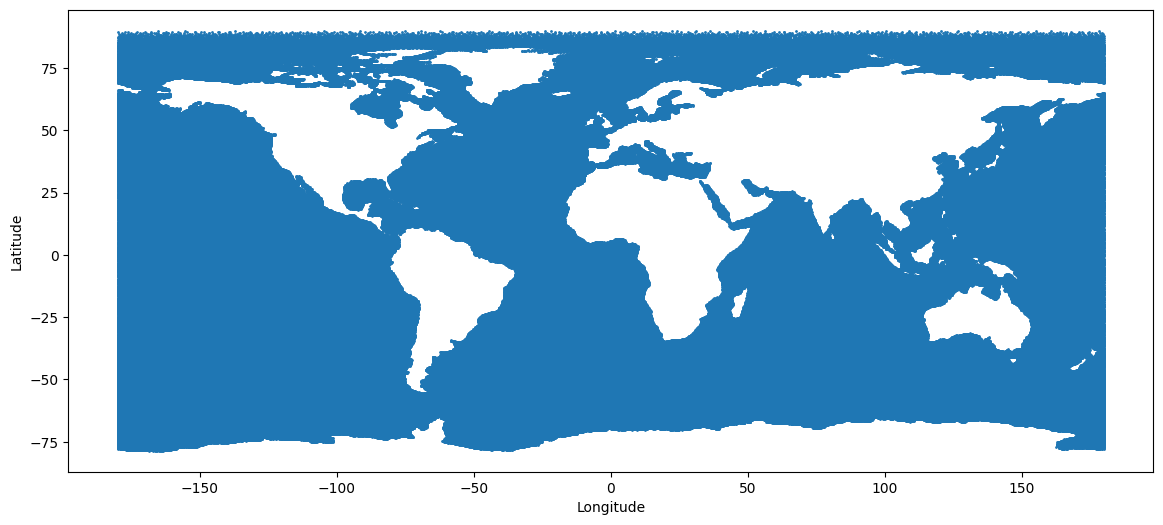

In [4]:
model_lon = data_mesh.lon.values
model_lat = data_mesh.lat.values

step = 10
plt.figure(figsize=(14, 6))
plt.scatter(model_lon[::step], model_lat[::step], s=1)
plt.xlabel('Longitude', size=10)
plt.ylabel('Latitude', size=10)

### Deletion of useless fields

In [5]:
vars_keys = data_mesh.data_vars
for key in vars_keys:
    if key != 'lat' and key != 'lon' and key != 'edges' and key != 'nodes':
        data_mesh = data_mesh.drop_vars(key)

data_mesh = data_mesh.drop_vars('nz')   # These 2 are coordinates, not variables
data_mesh = data_mesh.drop_vars('nz1')
data_mesh

<xarray.Dataset>
Dimensions:  (nod2: 8852366, n2: 2, edg_n: 26481174)
Dimensions without coordinates: nod2, n2, edg_n
Data variables:
    lon      (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat      (nod2) float64 -78.05 -78.05 -78.08 -78.02 ... -77.85 -77.82 -77.85
    nodes    (n2, nod2) float64 ...
    edges    (n2, edg_n) int32 ...

### RoI & Plot: South Atlantic mask extraction (Eddy-rich region)

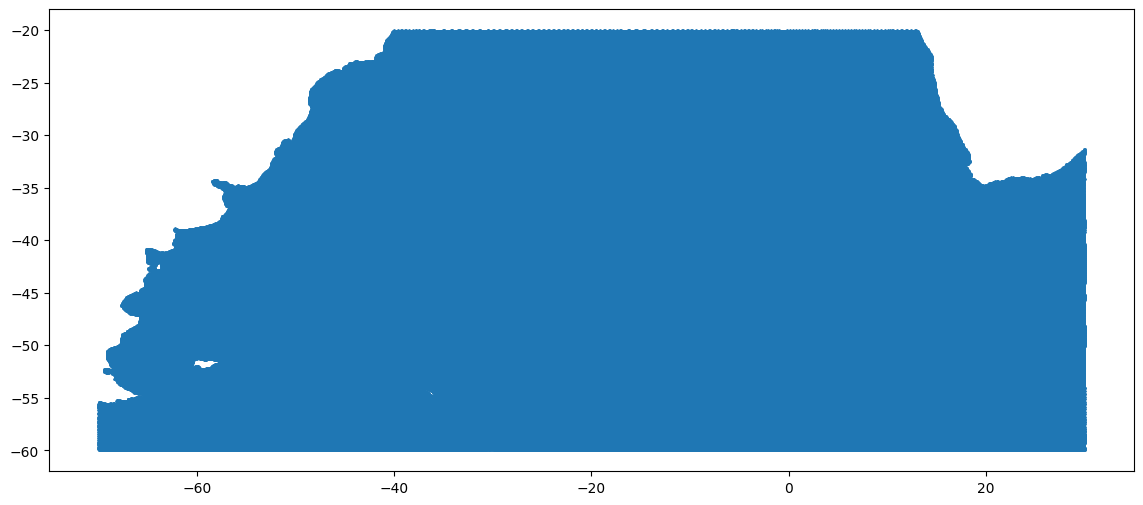

In [6]:
left = params['input_left']
right = params['input_right']
bottom = params['input_bottom']
top = params['input_top']
region_mask = (model_lon > left) & (model_lon < right) & (model_lat < top) & (model_lat > bottom)

step = 1
plt.figure(figsize=(14, 6))
plt.scatter(model_lon[region_mask][::step], model_lat[region_mask][::step], s=1)

### RoI: edges extraction

In [7]:
# Decrease by 1 since for compatibility with Fortran the indexes start from 1 instead of 0
edge_0 = data_mesh.edges[0].values
edge_1 = data_mesh.edges[1].values
edge_0 -= 1
edge_1 -= 1

edges_subset = []
for i in range(len(edge_0)):
    if region_mask[edge_0[i]] & region_mask[edge_1[i]]:
        edges_subset.append([edge_0[i], edge_1[i]])

edges_subset = np.array(edges_subset, dtype="int32")
data_mesh = data_mesh.drop_vars('edges')
data_mesh['edges'] = (('edges_subset', 'n2'), edges_subset)
data_mesh

<xarray.Dataset>
Dimensions:  (nod2: 8852366, n2: 2, edges_subset: 2268763)
Dimensions without coordinates: nod2, n2, edges_subset
Data variables:
    lon      (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat      (nod2) float64 -78.05 -78.05 -78.08 -78.02 ... -77.85 -77.82 -77.85
    nodes    (n2, nod2) float64 ...
    edges    (edges_subset, n2) int32 1035320 1035378 ... 7106912 7106914

### RoI: nodes extraction

In [8]:
nodes_subset = []
for i in range(len(region_mask)):
    if region_mask[i]:
        nodes_subset.append(i)

nodes_subset = np.array(nodes_subset, dtype="int32")
data_mesh['nodes'] =(('nodes_subset'), nodes_subset)
data_mesh

<xarray.Dataset>
Dimensions:  (nod2: 8852366, nodes_subset: 757747, edges_subset: 2268763, n2: 2)
Dimensions without coordinates: nod2, nodes_subset, edges_subset, n2
Data variables:
    lon      (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat      (nod2) float64 -78.05 -78.05 -78.08 -78.02 ... -77.85 -77.82 -77.85
    nodes    (nodes_subset) int32 1035320 1035324 1035345 ... 7853535 7853537
    edges    (edges_subset, n2) int32 1035320 1035378 ... 7106912 7106914

### Plot: final RoI

Text(0, 0.5, 'Latitude')

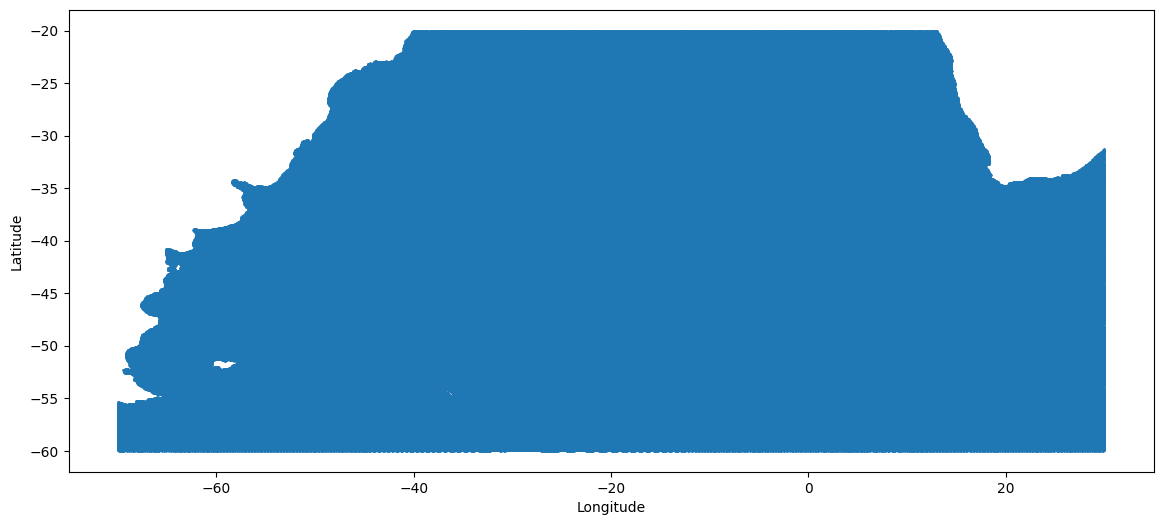

In [9]:
model_lon_roi = data_mesh.lon[data_mesh.nodes].values
model_lat_roi = data_mesh.lat[data_mesh.nodes].values

step = 1
plt.figure(figsize=(14, 6))
plt.scatter(model_lon_roi[::step], model_lat_roi[::step], s=1)
plt.xlabel('Longitude', size=10)
plt.ylabel('Latitude', size=10)

### Plot: just the connections of the RoI
##### (If everything is green is because the selected area is dense with edges)

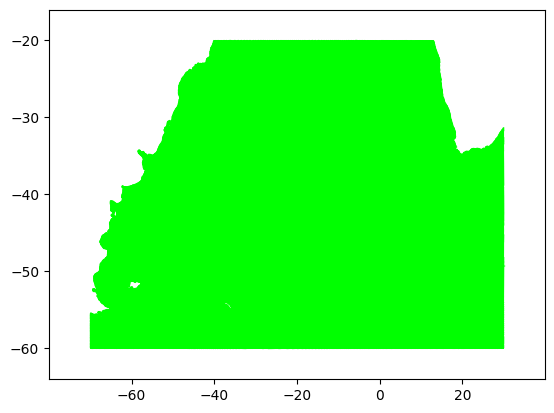

In [10]:
edge_0 = data_mesh.edges[:, 0].values
edge_1 = data_mesh.edges[:, 1].values
x_0 = []
y_0 = []
x_1 = []
y_1 = []
for i in range(edge_0.size):
    if region_mask[edge_0[i]] & region_mask[edge_1[i]]:
        # First the connection starting points
        x_0.append(float(model_lon[edge_0[i]]))
        y_0.append(float(model_lat[edge_0[i]]))
        # Then the connection end points
        x_1.append(float(model_lon[edge_1[i]]))
        y_1.append(float(model_lat[edge_1[i]]))

# Organizing the start and ending connection points for visualization
lines = []
for i in range(len(x_0)):
    lines.append([(x_0[i], y_0[i]), (x_1[i], y_1[i])])

# Color mask to green
c = [(0, 1, 0, 1)]*len(x_0)

lc = mc.LineCollection(lines, colors=c, linewidths=1)
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.margins(0.1)
plt.show()

### Save the subset mesh(optional)

In [11]:
#data_mesh.to_netcdf(OUTPUT_PATH_GRID_SUBSET, engine='netcdf4')

### Inspect a filtered SSH file and its segmentation mask for the year defined in the .yaml file

In [12]:
year = str(params['year'])

data = []
for file in os.listdir(INPUT_PATH_SEG_MASKS):
    if year in file:
        data.append(file)

data.sort()

# Let's take February
data_02 = xr.open_dataset(INPUT_PATH_SEG_MASKS + '/' + data[1])

In [13]:
data_02

<xarray.Dataset>
Dimensions:    (LONGITUDE: 1200, LATITUDE: 480, TIME: 28)
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 -70.0 -69.92 -69.83 ... 29.75 29.83 29.92
  * LATITUDE   (LATITUDE) float32 -60.0 -59.92 -59.83 ... -20.25 -20.17 -20.08
  * TIME       (TIME) float32 5.706e+05 5.706e+05 ... 5.712e+05 5.712e+05
Data variables:
    ssh        (TIME, LONGITUDE, LATITUDE) float64 ...
    seg_mask   (TIME, LONGITUDE, LATITUDE) int64 ...

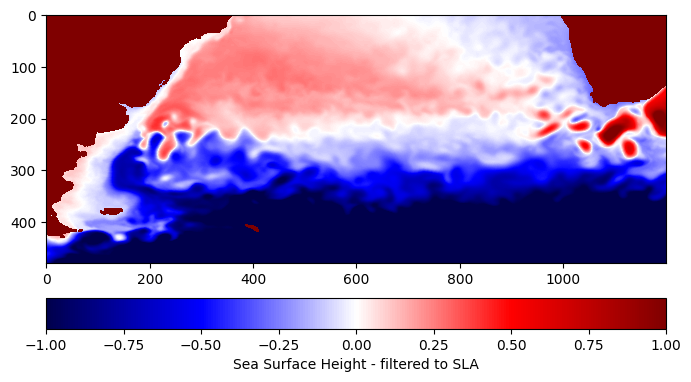

In [14]:
plot_data = data_02.ssh.values[0]

fig = plt.figure(figsize=(8, 4.5))
plt.imshow(np.flipud(plot_data.T), cmap=cm.seismic, vmin=-1, vmax=1)
cb = plt.colorbar(orientation='horizontal', pad=0.1)
cb.set_label('Sea Surface Height - filtered to SLA', size=10)

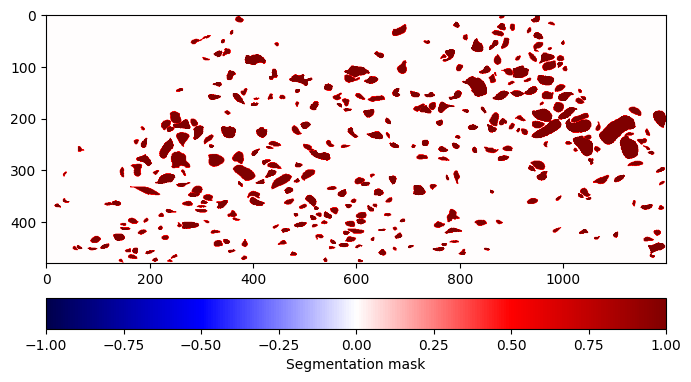

In [15]:
plot_data = data_02.seg_mask.values[0]

fig = plt.figure(figsize=(8, 4.5))
plt.imshow(np.flipud(plot_data.T), cmap=cm.seismic, vmin=-1, vmax=1)
cb = plt.colorbar(orientation='horizontal', pad=0.1)
cb.set_label('Segmentation mask', size=10)

## Interpolation of SSH and segmentation mask to the unstructured subset grid

### First, some helper functions from https://github.com/nextGEMS/nextGEMS_Cycle3/blob/main/FESOM/STARTHERE_FESOM.ipynb

In [16]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [17]:
def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(lons.flatten(), lats.flatten())
    xt, yt, zt = lon_lat_to_cartesian(model_lon, model_lat)

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

In [18]:
from scipy.spatial import cKDTree

# Target coordinates(the unstructured FESOM mesh)
model_lon = data_mesh.lon[data_mesh.nodes].values
model_lat = data_mesh.lat[data_mesh.nodes].values

# Source coordinates(the SSH and segmentation masks information)
data_lon, data_lat = np.meshgrid(data_02['LONGITUDE'], data_02['LATITUDE'])

data_lon = data_lon.T
data_lat = data_lat.T

# SSH values
data_ssh_values = data_02.ssh.values[0]
data_ssh_values[np.abs(data_ssh_values) > 100] = np.nan

# Segmentation mask
data_seg_mask_values = data_02.seg_mask.values[0]

print(np.shape(model_lon))
print(np.shape(model_lat))
print(np.shape(data_lon))
print(np.shape(data_lat))
print(np.shape(data_ssh_values))

(757747,)
(757747,)
(1200, 480)
(1200, 480)
(1200, 480)


In [19]:
distances, inds = create_indexes_and_distances(model_lon, model_lat, data_lon, data_lat, k=1, workers=-1)

In [20]:
distances.shape, inds.shape, min(inds), max(inds)

((757747,), (757747,), 1, 575865)

In [21]:
flat_ssh = data_ssh_values.flatten()
flat_seg_mask = data_seg_mask_values.flatten()

ssh = flat_ssh[inds]
seg_mask = flat_seg_mask[inds]

radius_of_influence = 10000

ssh[distances >= radius_of_influence] = np.nan
ssh = np.ma.masked_invalid(ssh)

seg_mask[distances >= radius_of_influence] = 0
seg_mask = np.ma.masked_invalid(seg_mask)

In [22]:
np.min(ssh), np.max(ssh), min(distances), max(distances)

(-1.8223326206207275, 1.3817895650863647, 2.996811811857859, 9859.58150920928)

### Store the newly created SSH and seg_mask variables in the subset mesh

In [23]:
ssh = np.array(ssh, dtype="float64")
data_mesh['ssh'] = (('nodes_subset'), ssh)

seg_mask = np.array(seg_mask, dtype="float64")  # TODO the seg mask should be int64, but with nan values I had problems
data_mesh['seg_mask'] = (('nodes_subset'), seg_mask)

data_mesh

<xarray.Dataset>
Dimensions:   (nod2: 8852366, nodes_subset: 757747, edges_subset: 2268763, n2: 2)
Dimensions without coordinates: nod2, nodes_subset, edges_subset, n2
Data variables:
    lon       (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat       (nod2) float64 -78.05 -78.05 -78.08 ... -77.85 -77.82 -77.85
    nodes     (nodes_subset) int32 1035320 1035324 1035345 ... 7853535 7853537
    edges     (edges_subset, n2) int32 1035320 1035378 ... 7106912 7106914
    ssh       (nodes_subset) float64 -0.4388 -0.4306 -0.4346 ... -1.811 -1.812
    seg_mask  (nodes_subset) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

### Loss of information when going from structured SSH/seg_mask to unstructured

In [24]:
not_nan_ssh = np.count_nonzero(~np.isnan(data_mesh.ssh.values))
not_nan_ssh_actual_proportion = not_nan_ssh*100/data_mesh.dims['nodes_subset']

print(f"Nodes with initial SSH data:\t\t\t\t{data_mesh.dims['nodes_subset']}")
print(f"Nodes with SSH/seg_mask data after pre-processing:\t{not_nan_ssh}")
print(f"Actual % of SSH/seg_mask info after pre-processing:\t {not_nan_ssh_actual_proportion:.3f}%")

Nodes with initial SSH data:				757747
Nodes with SSH/seg_mask data after pre-processing:	756778
Actual % of SSH/seg_mask info after pre-processing:	 99.872%


### Group of plots to understand where we started and where we got

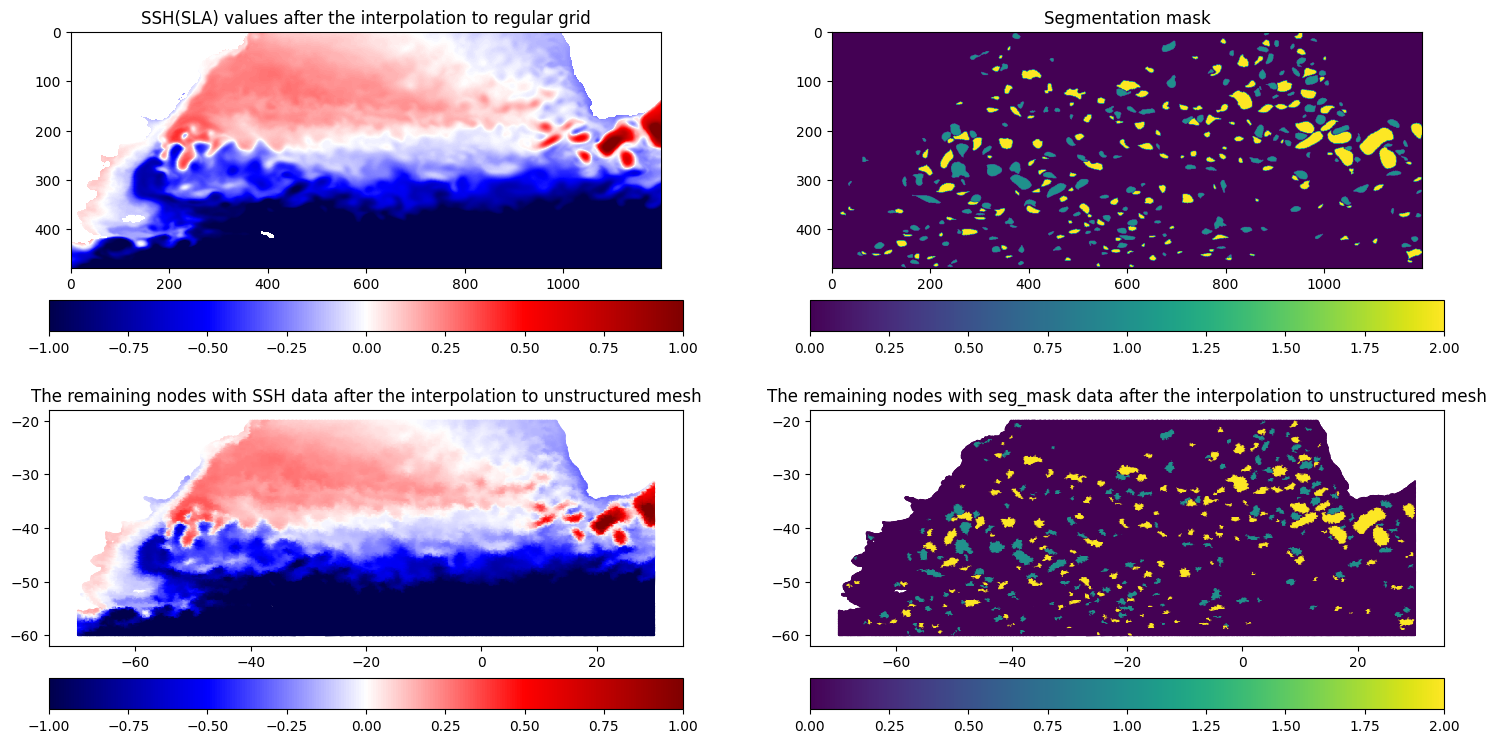

In [25]:
model_lon_roi = data_mesh.lon[data_mesh.nodes].values
model_lat_roi = data_mesh.lat[data_mesh.nodes].values
uns_ssh = data_mesh.ssh.values
str_ssh = data_02.ssh.values[0]
uns_seg_mask = data_mesh.seg_mask.values
str_seg_mask = data_02.seg_mask.values[0]

fig, axes = plt.subplots(2, 2, figsize=(18, 9))

im = axes[0][0].imshow(np.flipud(str_ssh.T), cmap=cm.seismic, vmin=-1, vmax=1)
axes[0][0].set_title("SSH(SLA) values after the interpolation to regular grid")
cb = plt.colorbar(im, orientation='horizontal', pad=0.1, ax=axes[0][0])

im2 = axes[0][1].imshow(np.flipud(str_seg_mask.T), cmap=cm.viridis, vmin=0, vmax=2)
axes[0][1].set_title("Segmentation mask")
cb = plt.colorbar(im2, orientation='horizontal', pad=0.1, ax=axes[0][1])

im3 = axes[1][0].scatter(model_lon_roi, model_lat_roi, c=uns_ssh, s=0.1, cmap=cm.seismic, vmin=-1, vmax=1)
axes[1][0].set_title(f"The remaining nodes with SSH data after the interpolation to unstructured mesh")
plt.colorbar(im3, orientation='horizontal', pad=0.1, ax=axes[1][0])

im4 = axes[1][1].scatter(model_lon_roi, model_lat_roi, c=uns_seg_mask, s=0.1, cmap=cm.viridis, vmin=0, vmax=2)
axes[1][1].set_title(f"The remaining nodes with seg_mask data after the interpolation to unstructured mesh")
plt.colorbar(im4, orientation='horizontal', pad=0.1, ax=axes[1][1])

#plt.close()

### Zoomed-in plots to better inspect the resulting data

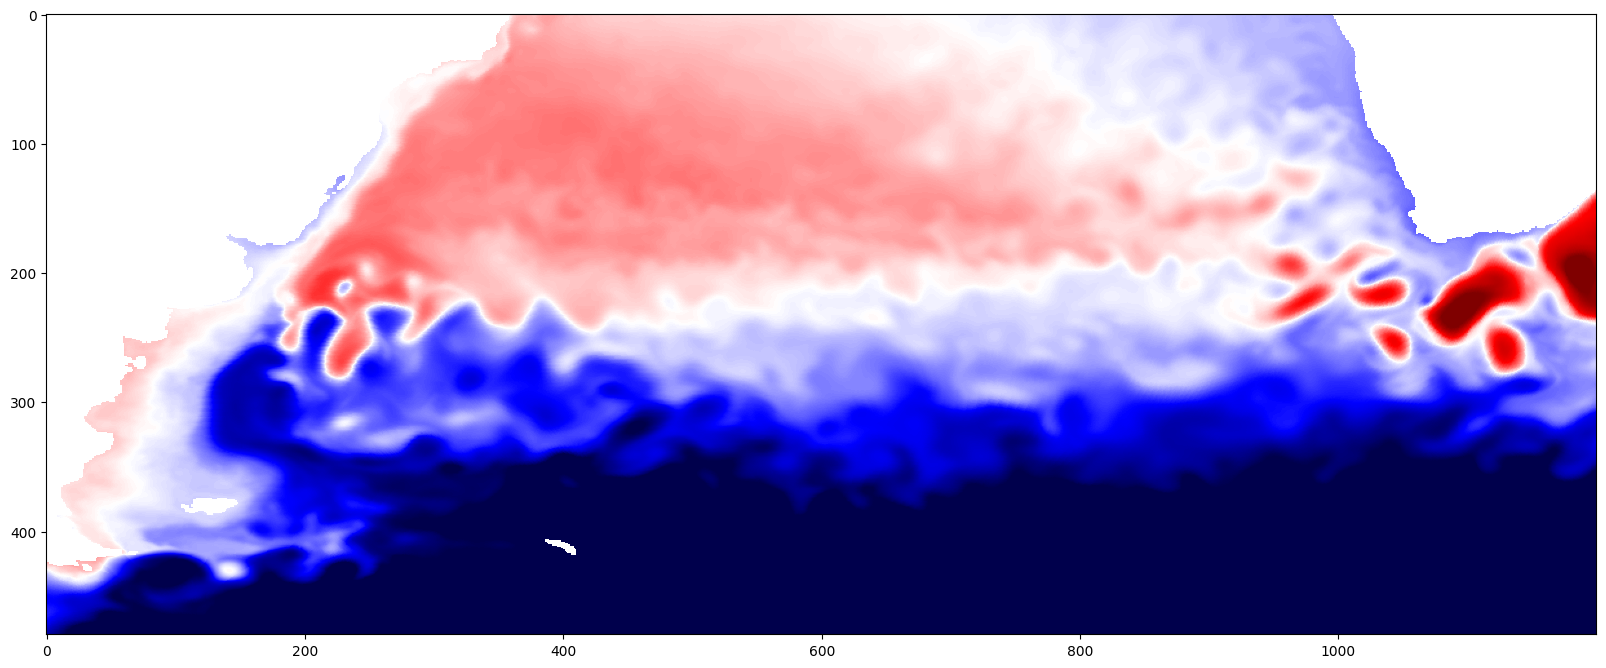

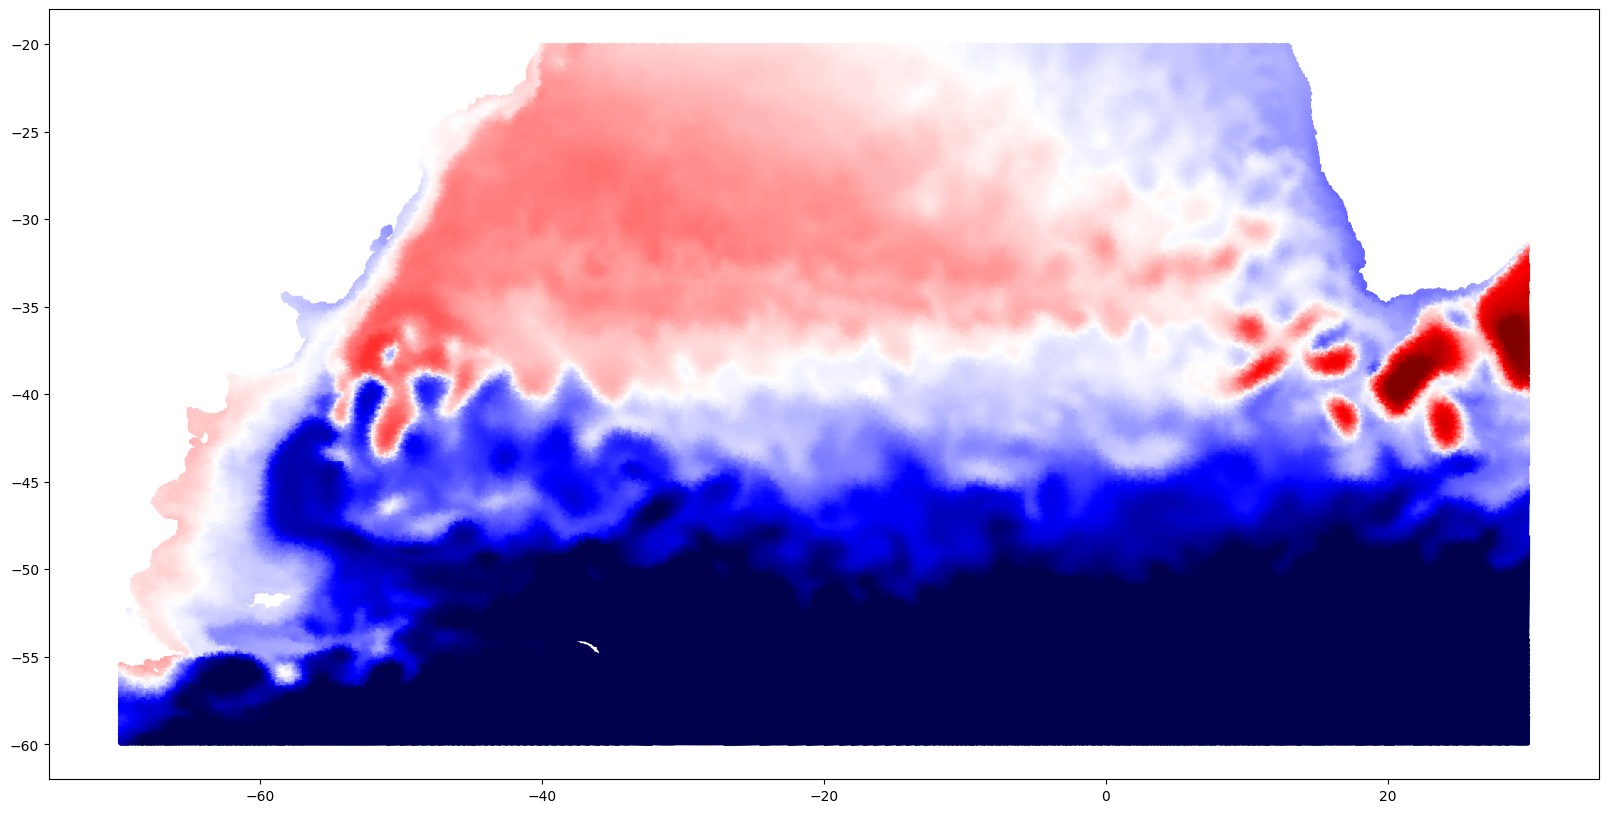

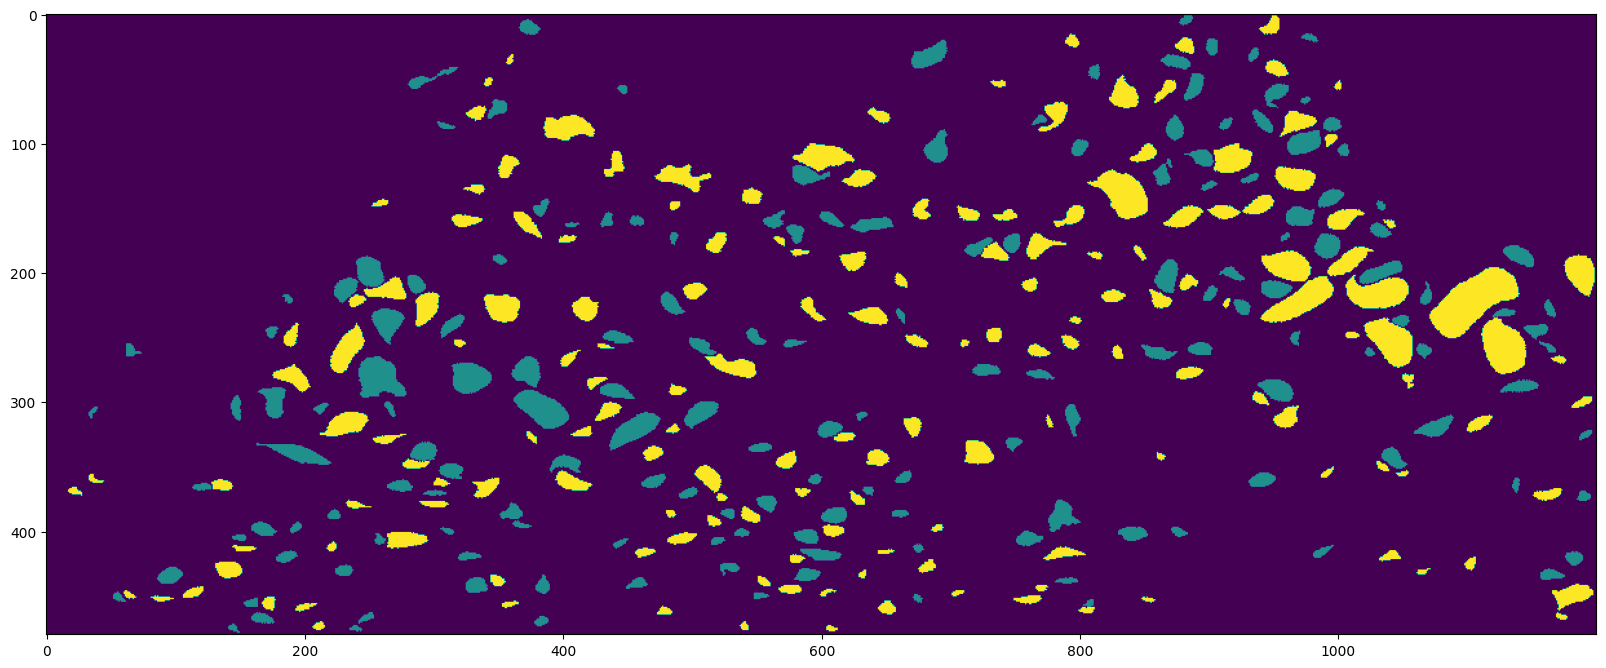

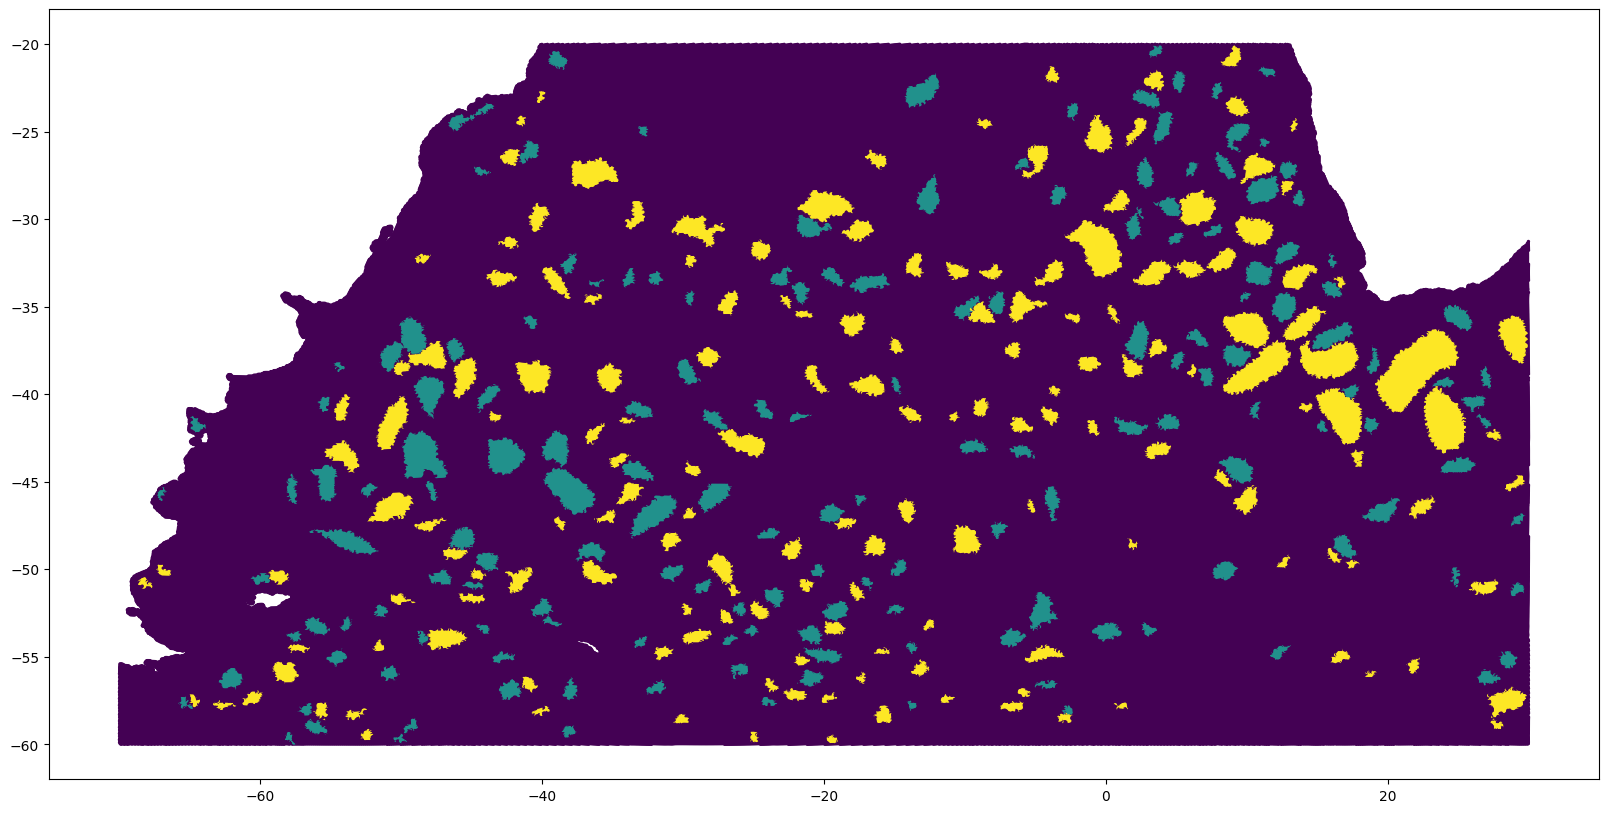

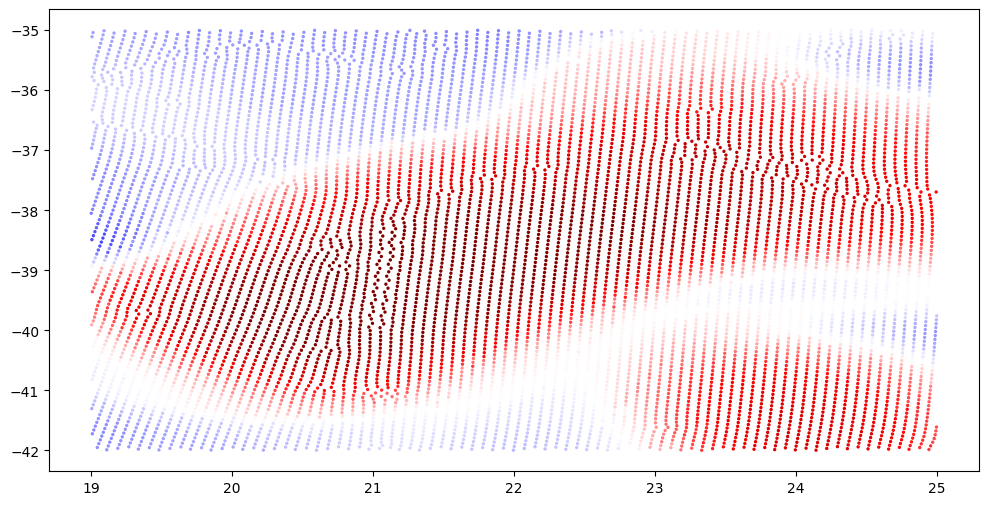

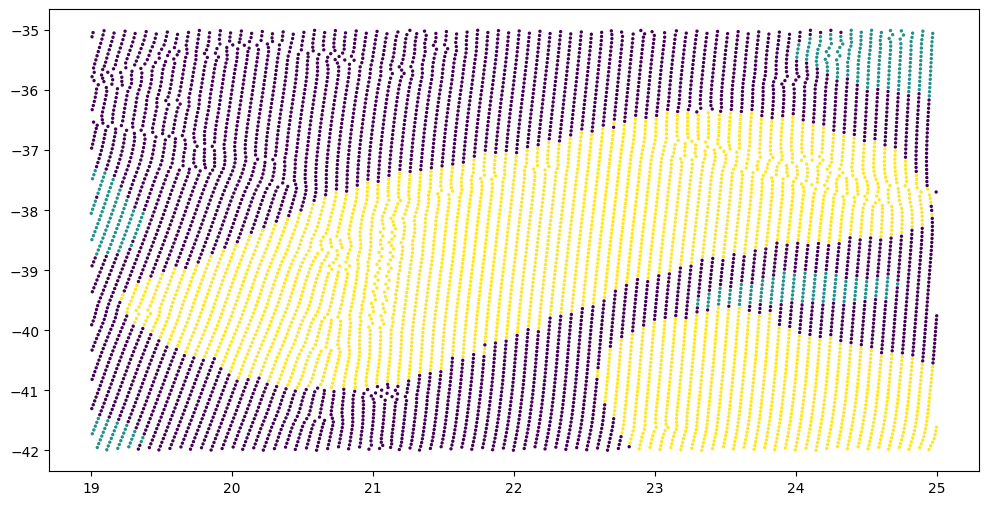

In [26]:
model_lon_roi = data_mesh.lon[data_mesh.nodes].values
model_lat_roi = data_mesh.lat[data_mesh.nodes].values

uns_ssh = data_mesh.ssh.values
str_ssh = data_02.ssh.values[0]
uns_seg_mask = data_mesh.seg_mask.values
str_seg_mask = data_02.seg_mask.values[0]

left = params['input_left']
right = params['input_right']
top = params['input_top']
bottom = params['input_bottom']
region_mask = (model_lon_roi > left) & (model_lon_roi < right) & (model_lat_roi < top) & (model_lat_roi > bottom)

plt.figure(figsize=(20, 10))
im = plt.imshow(np.flipud(str_ssh.T), cmap=cm.seismic, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(20, 10))
im = plt.scatter(model_lon_roi[region_mask], model_lat_roi[region_mask], c=uns_ssh[region_mask], s=2, cmap=cm.seismic, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(20, 10))
im = plt.imshow(np.flipud(str_seg_mask.T), cmap=cm.viridis, vmin=0, vmax=2)
plt.show()

plt.figure(figsize=(20, 10))
im = plt.scatter(model_lon_roi[region_mask], model_lat_roi[region_mask], c=uns_seg_mask[region_mask], s=2, cmap=cm.viridis, vmin=0, vmax=2)
plt.show()

left = 19
right = 25
top = -35
bottom = -42
region_mask = (model_lon_roi > left) & (model_lon_roi < right) & (model_lat_roi < top) & (model_lat_roi > bottom)

plt.figure(figsize=(12, 6))
im = plt.scatter(model_lon_roi[region_mask], model_lat_roi[region_mask], c=uns_ssh[region_mask], s=2, cmap=cm.seismic, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(12, 6))
im = plt.scatter(model_lon_roi[region_mask], model_lat_roi[region_mask], c=uns_seg_mask[region_mask], s=2, cmap=cm.viridis, vmin=0, vmax=2)
plt.show()

### Duplication of matrix cells per amount of mesh nodes

In [27]:
'''
bins = np.unique(inds)
counts, edges, bars = plt.hist(inds, bins=bins, edgecolor='black')
plt.xlabel("Matrix cells", labelpad=12, fontsize=14)
plt.ylabel("Mesh nodes associated per matrix cell", labelpad=12, fontsize=14)
'''

'\nbins = np.unique(inds)\ncounts, edges, bars = plt.hist(inds, bins=bins, edgecolor=\'black\')\nplt.xlabel("Matrix cells", labelpad=12, fontsize=14)\nplt.ylabel("Mesh nodes associated per matrix cell", labelpad=12, fontsize=14)\n'